# 1 preparing the data and workflow

The problem it to predict customres who can not be able to pay the car loan using machin learning models and choose one with the best effect

##  Set the view and install necessary libraries

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [137]:
import numpy as np
import pandas as pd
import datetime
import re
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost
from matplotlib.pyplot import figure

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, GridSearchCV

from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import StandardScaler

from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats.distributions import uniform, randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn import  metrics


In [138]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## Download the data set

In [330]:
dataset = pd.read_csv('train.csv')
dataset.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


## I have to reduce the data because i'm not able to train models

In [331]:
val_true = dataset[dataset['loan_default']==1]
val_false = dataset[dataset['loan_default']==0]

val_false.reset_index(drop=True)
val_true.reset_index(drop=True)

val_false=val_false.sample(n=25_000, random_state=1)
# val_false.reset_index(drop=True)

val_true=val_true.sample(n=10_000, random_state=1)    
# val_true.reset_index(drop=True)

dataset = pd.concat([val_true,val_false])
dataset.reset_index(drop=True) 
# dataset = dataset.groupby('loan_default').sample(n=10_500, random_state=1) # po 8k każdy 50/50
dataset['loan_default'].value_counts()

0    25000
1    10000
Name: loan_default, dtype: int64

## Checking how the data looks like


In [332]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35000 entries, 176507 to 19956
Data columns (total 41 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   UniqueID                             35000 non-null  int64  
 1   disbursed_amount                     35000 non-null  int64  
 2   asset_cost                           35000 non-null  int64  
 3   ltv                                  35000 non-null  float64
 4   branch_id                            35000 non-null  int64  
 5   supplier_id                          35000 non-null  int64  
 6   manufacturer_id                      35000 non-null  int64  
 7   Current_pincode_ID                   35000 non-null  int64  
 8   Date.of.Birth                        35000 non-null  object 
 9   Employment.Type                      33870 non-null  object 
 10  DisbursalDate                        35000 non-null  object 
 11  State_ID               

In [333]:
dataset.describe()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,NO.OF_INQUIRIES,loan_default
count,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.0,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000,3.500000e+04,3.500000e+04,3.500000e+04,35000.000000,35000.000000,35000.000000,3.500000e+04,3.500000e+04,3.500000e+04,3.500000e+04,35000.000000,35000.000000,35000.000000,35000.000000,35000.000000
mean,536582.040914,54533.904714,75858.723314,74.964740,73.095343,19669.001914,68.912514,3422.260971,7.267686,1546.682857,1.0,0.835857,0.076914,0.150714,0.023000,0.001971,284.430114,2.369257,1.021229,0.161514,1.623146e+05,2.106771e+05,2.101135e+05,0.054429,0.025314,0.007029,5.555423e+03,8.072276e+03,7.958067e+03,1.321201e+04,189.780171,0.370114,0.098629,0.206400,0.285714
std,68526.886176,12680.842224,18366.581640,11.324778,70.184223,3489.199281,22.250222,2242.572598,4.463333,977.532661,0.0,0.370410,0.266459,0.357775,0.149905,0.044358,336.550508,4.993832,2.032671,0.565389,8.440727e+05,1.103660e+06,1.103680e+06,0.617731,0.291384,0.106138,1.604457e+05,2.043909e+05,2.036545e+05,1.725165e+05,5920.396116,0.930966,0.382312,0.689377,0.451760
min,417428.000000,13664.000000,38059.000000,10.030000,1.000000,10524.000000,45.000000,1.000000,1.000000,1.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.678296e+06,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,-2.029000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,477214.750000,47349.000000,65714.000000,69.240000,14.000000,16565.000000,48.000000,1514.000000,4.000000,704.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
50%,537141.500000,53940.000000,70948.000000,77.050000,61.000000,20379.000000,86.000000,2981.000000,6.000000,1451.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
75%,596294.500000,60613.000000,79488.250000,83.740000,130.000000,23020.000000,86.000000,5698.000000,10.000000,2357.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,669.250000,3.000000,1.000000,0.000000,3.296925e+04,6.014250e+04,5.952400e+04,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.952000e+03,0.000000,0.000000,0.000000,0.000000,1.000000
max,658664.000000,170146.000000,259000.000000,95.000000,261.000000,24803.000000,153.000000,7345.000000,22.000000,3791.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,879.000000,194.000000,144.000000,23.000000,4.505116e+07,9.262282e+07,9.262873e+07,46.000000,21.000000,8.000000,1.963828e+07,1.980000e+07,1.980000e+07,1.551855e+07,497489.000000,23.000000,8.000000,18.000000,1.000000


In [334]:
dataset.isnull().sum()

UniqueID                                  0
disbursed_amount                          0
asset_cost                                0
ltv                                       0
branch_id                                 0
supplier_id                               0
manufacturer_id                           0
Current_pincode_ID                        0
Date.of.Birth                             0
Employment.Type                        1130
DisbursalDate                             0
State_ID                                  0
Employee_code_ID                          0
MobileNo_Avl_Flag                         0
Aadhar_flag                               0
PAN_flag                                  0
VoterID_flag                              0
Driving_flag                              0
Passport_flag                             0
PERFORM_CNS.SCORE                         0
PERFORM_CNS.SCORE.DESCRIPTION             0
PRI.NO.OF.ACCTS                           0
PRI.ACTIVE.ACCTS                

## Checking how looks like churn / non-churn split

In [335]:
dataset['loan_default'].value_counts()

0    25000
1    10000
Name: loan_default, dtype: int64

## Change string value into numeric one

In [336]:
dataset[['AVERAGE_y','AVERAGE_m']]= [x.split(' ') for x in dataset['AVERAGE.ACCT.AGE']]
dataset['AVERAGE_y']  = [ re.sub("[^0-9]", "", x) for x in dataset['AVERAGE_y']]
dataset['AVERAGE_y'] = pd.to_numeric(dataset['AVERAGE_y'])
dataset['AVERAGE_m']  = [ re.sub("[^0-9]", "", x) for x in dataset['AVERAGE_m']]
dataset['AVERAGE_m']  = pd.to_numeric(dataset['AVERAGE_m'])
dataset['AVERAGE.ACCT.AGE'] =  (dataset['AVERAGE_y']*12)+ dataset['AVERAGE_m']


In [337]:
dataset[['CREDIT_y','CREDIT_m']]= [x.split(' ') for x in dataset['CREDIT.HISTORY.LENGTH']]
dataset['CREDIT_y']  = [ re.sub("[^0-9]", "", x) for x in dataset['CREDIT_y']]
dataset['CREDIT_y'] = pd.to_numeric(dataset['CREDIT_y'])
dataset['CREDIT_m']  = [ re.sub("[^0-9]", "", x) for x in dataset['CREDIT_m']]
dataset['CREDIT_m']  = pd.to_numeric(dataset['CREDIT_m'])
dataset['CREDIT.HISTORY.LENGTH'] =  (dataset['CREDIT_y']*12)+ dataset['CREDIT_m']


## Change date to date value

In [338]:
def change_to_date(dataset,column):
    dataset[column]=[datetime.datetime.strptime(x,"%d-%m-%y") for x in dataset[column]]
    
    
change_to_date(dataset,'Date.of.Birth')


In [339]:
    
change_to_date(dataset,'DisbursalDate')

## Drop supperted columns

In [340]:
dataset.drop(columns=['AVERAGE_y','AVERAGE_m','CREDIT_y','CREDIT_m'],inplace=True)


## Checking unique values in each column

In [341]:
calumn_list = list()

number_of_unique_values = list()

for column in dataset.columns :
    calumn_list.append((column,dataset[column].nunique()))
# calumn_list

## Checking unique values for each column

In [342]:
dataset.nunique()

UniqueID                               35000
disbursed_amount                        7898
asset_cost                             18167
ltv                                     4881
branch_id                                 82
supplier_id                             2507
manufacturer_id                            9
Current_pincode_ID                      4752
Date.of.Birth                          10318
Employment.Type                            2
DisbursalDate                             84
State_ID                                  22
Employee_code_ID                        3051
MobileNo_Avl_Flag                          1
Aadhar_flag                                2
PAN_flag                                   2
VoterID_flag                               2
Driving_flag                               2
Passport_flag                              2
PERFORM_CNS.SCORE                        552
PERFORM_CNS.SCORE.DESCRIPTION             20
PRI.NO.OF.ACCTS                           75
PRI.ACTIVE

## Delete unnecessary columns

In [343]:
dataset.drop(columns=['UniqueID','MobileNo_Avl_Flag'],inplace=True)

## Checking the data again

In [344]:
different_value=dataset.columns.to_series().groupby(dataset.dtypes).groups
different_value

{int64: ['disbursed_amount', 'asset_cost', 'branch_id', 'supplier_id', 'manufacturer_id', 'Current_pincode_ID', 'State_ID', 'Employee_code_ID', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag', 'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE', 'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT', 'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS', 'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT', 'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT', 'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES', 'loan_default'], float64: ['ltv'], datetime64[ns]: ['Date.of.Birth', 'DisbursalDate'], object: ['Employment.Type', 'PERFORM_CNS.SCORE.DESCRIPTION']}

In [345]:
dataset.isna().sum()

disbursed_amount                          0
asset_cost                                0
ltv                                       0
branch_id                                 0
supplier_id                               0
manufacturer_id                           0
Current_pincode_ID                        0
Date.of.Birth                             0
Employment.Type                        1130
DisbursalDate                             0
State_ID                                  0
Employee_code_ID                          0
Aadhar_flag                               0
PAN_flag                                  0
VoterID_flag                              0
Driving_flag                              0
Passport_flag                             0
PERFORM_CNS.SCORE                         0
PERFORM_CNS.SCORE.DESCRIPTION             0
PRI.NO.OF.ACCTS                           0
PRI.ACTIVE.ACCTS                          0
PRI.OVERDUE.ACCTS                         0
PRI.CURRENT.BALANCE             

In [346]:
dataset['Employment.Type'].value_counts()

Self employed    19359
Salaried         14511
Name: Employment.Type, dtype: int64

## Most of the type of employment is self-employment, so I will overwrite the 3% of the missing values with the most popular one

In [347]:
dataset['Employment.Type'].fillna(value=dataset['Employment.Type'].value_counts().index[0],inplace=True)
dataset['Employment.Type'].value_counts()

Self employed    20489
Salaried         14511
Name: Employment.Type, dtype: int64

In [348]:
dataset.isna().sum().sum()

0

#  I have to change int value to float

In [349]:
column_to_convert = list()

for column,types in zip(dataset.columns,dataset.dtypes):
    if types == 'int64': 
        column_to_convert.append(column)
column_to_convert


dataset[column_to_convert] = dataset[column_to_convert].astype(float)

## to check data I need to change from non-numeric  to numeric value

In [350]:
pca_data = copy.deepcopy(dataset)


### selecting  category values 

In [351]:
column_to_cat = list()

for column,types in zip(pca_data.columns,pca_data.dtypes):
    if  types =='float64' or types == 'int64':
        continue
    else:
        column_to_cat.append(column)
column_to_cat



['Date.of.Birth',
 'Employment.Type',
 'DisbursalDate',
 'PERFORM_CNS.SCORE.DESCRIPTION']

### selecting numeric values

In [352]:
column_to_convert = list()

for column,types in zip(pca_data.columns,pca_data.dtypes):
    if types == 'int64' or types == 'int32' : 
        column_to_convert.append(column)
column_to_convert


pca_data[column_to_convert] = pca_data[column_to_convert].astype(float)

In [353]:
label_encoder = LabelEncoder()
for column in pca_data[column_to_cat]:
    pca_data[column]= label_encoder.fit_transform(pca_data[column])


In [354]:
column_to_num = list()

for column,types in zip(pca_data.columns,pca_data.dtypes):
    if  types =='float64' or types == 'int64' or types == 'int32':
        column_to_num.append(column)
    else:
        continue    

In [355]:
pca_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35000 entries, 176507 to 19956
Data columns (total 39 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   disbursed_amount                     35000 non-null  float64
 1   asset_cost                           35000 non-null  float64
 2   ltv                                  35000 non-null  float64
 3   branch_id                            35000 non-null  float64
 4   supplier_id                          35000 non-null  float64
 5   manufacturer_id                      35000 non-null  float64
 6   Current_pincode_ID                   35000 non-null  float64
 7   Date.of.Birth                        35000 non-null  int64  
 8   Employment.Type                      35000 non-null  int64  
 9   DisbursalDate                        35000 non-null  int64  
 10  State_ID                             35000 non-null  float64
 11  Employee_code_ID       

## Checking importance of columns

## Check correlation between columns and delete non-importance

In [356]:
dataset2 = pca_data[column_to_num]

correlations = dataset2.corrwith(dataset2['loan_default'])
correlations = correlations[correlations!=1]
# correlations=correlations.drop(columns='loan_default',inplace=True)
positive_correlations = correlations[correlations >0].sort_values(ascending = False)
negative_correlations = correlations[correlations<0].sort_values(ascending = False)

print('Most Positive Correlations: \n', positive_correlations)
print('\nMost Negative Correlations: \n', negative_correlations)


Most Positive Correlations: 
 ltv                                    0.110448
disbursed_amount                       0.086324
PERFORM_CNS.SCORE.DESCRIPTION          0.076348
State_ID                               0.059304
VoterID_flag                           0.057958
NO.OF_INQUIRIES                        0.049083
branch_id                              0.047217
DisbursalDate                          0.039531
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS    0.039491
Current_pincode_ID                     0.032223
PRI.OVERDUE.ACCTS                      0.031306
Employment.Type                        0.030040
supplier_id                            0.026031
Employee_code_ID                       0.023650
Date.of.Birth                          0.017878
asset_cost                             0.014357
Driving_flag                           0.004219
dtype: float64

Most Negative Correlations: 
 SEC.OVERDUE.ACCTS              -0.000170
PAN_flag                       -0.002645
SEC.DISBURSED.AMOUNT      

Text(0.5, 1.0, 'Correlation with Churn Rate \n')

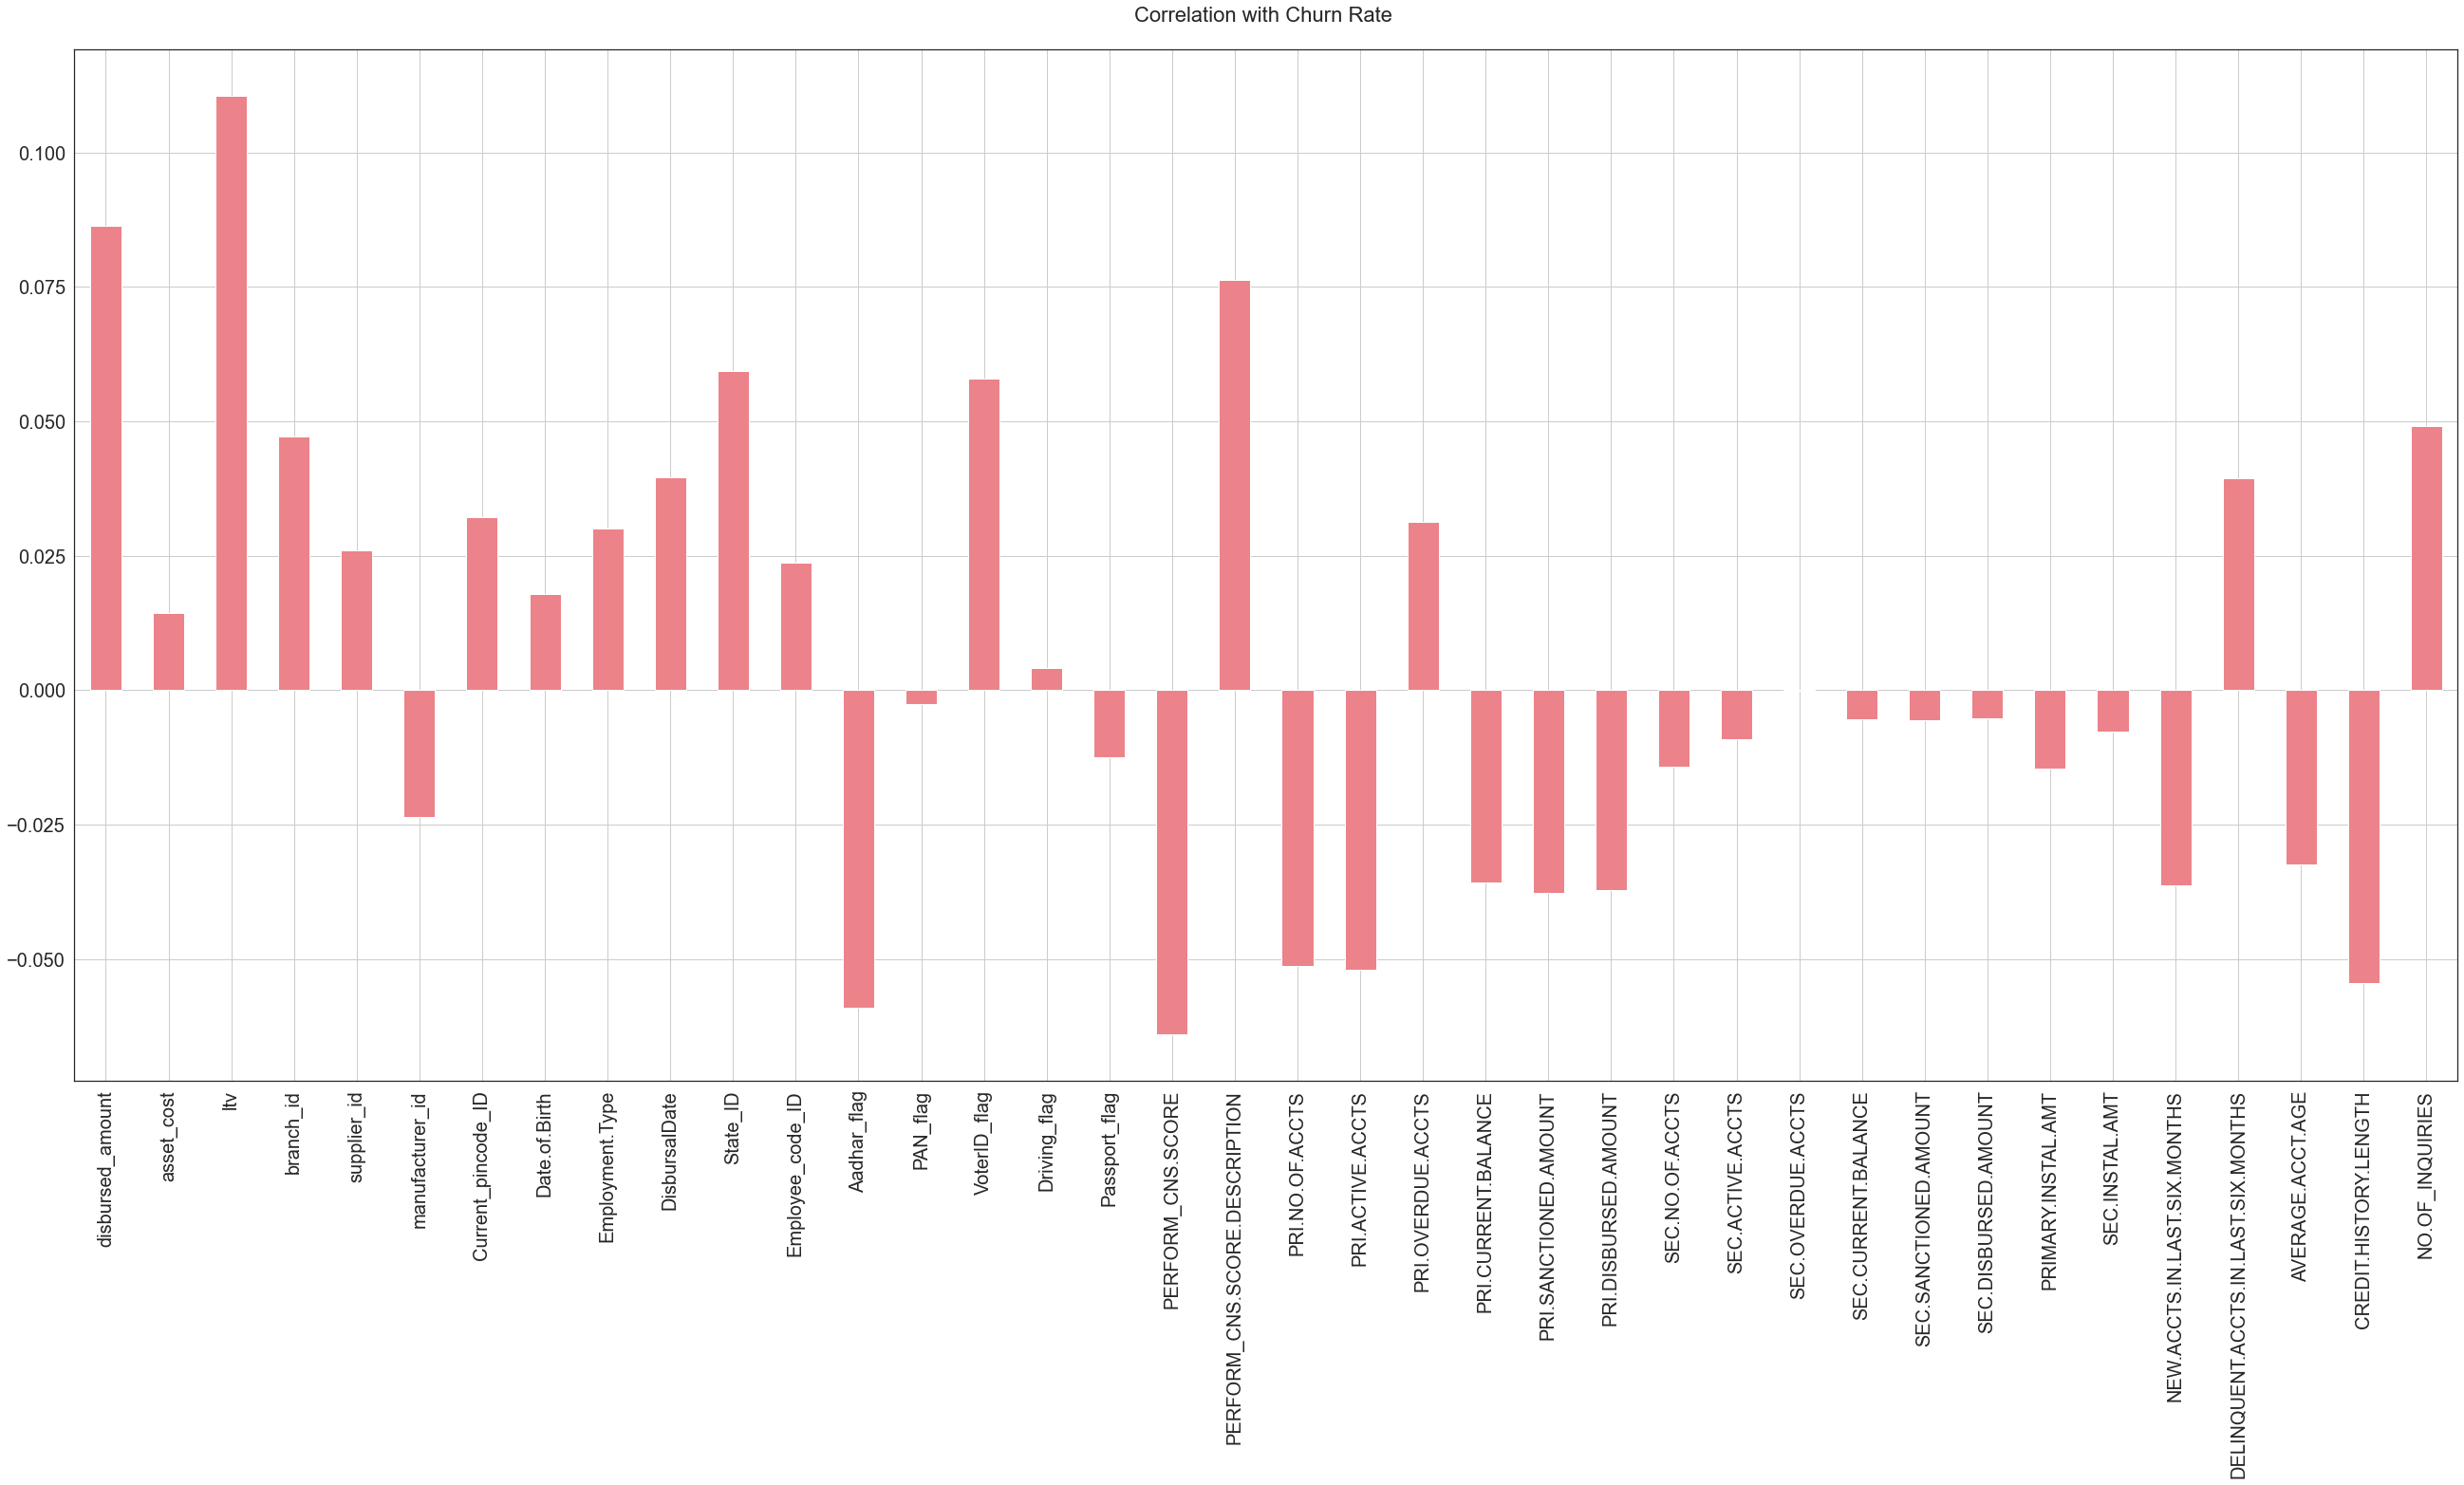

In [357]:
orrelations = dataset2.corrwith(pca_data['loan_default'])
correlations = correlations[correlations<0.99]

correlations.plot.bar(
        figsize = (45, 20), fontsize = 20, color = '#ec838a',
        rot = 90, grid = True)

plt.title('Correlation with Churn Rate \n',horizontalalignment="center", fontstyle = "normal", fontsize = "22", fontfamily = "sans-serif")


<ipython-input-358-b6b37baf9513>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

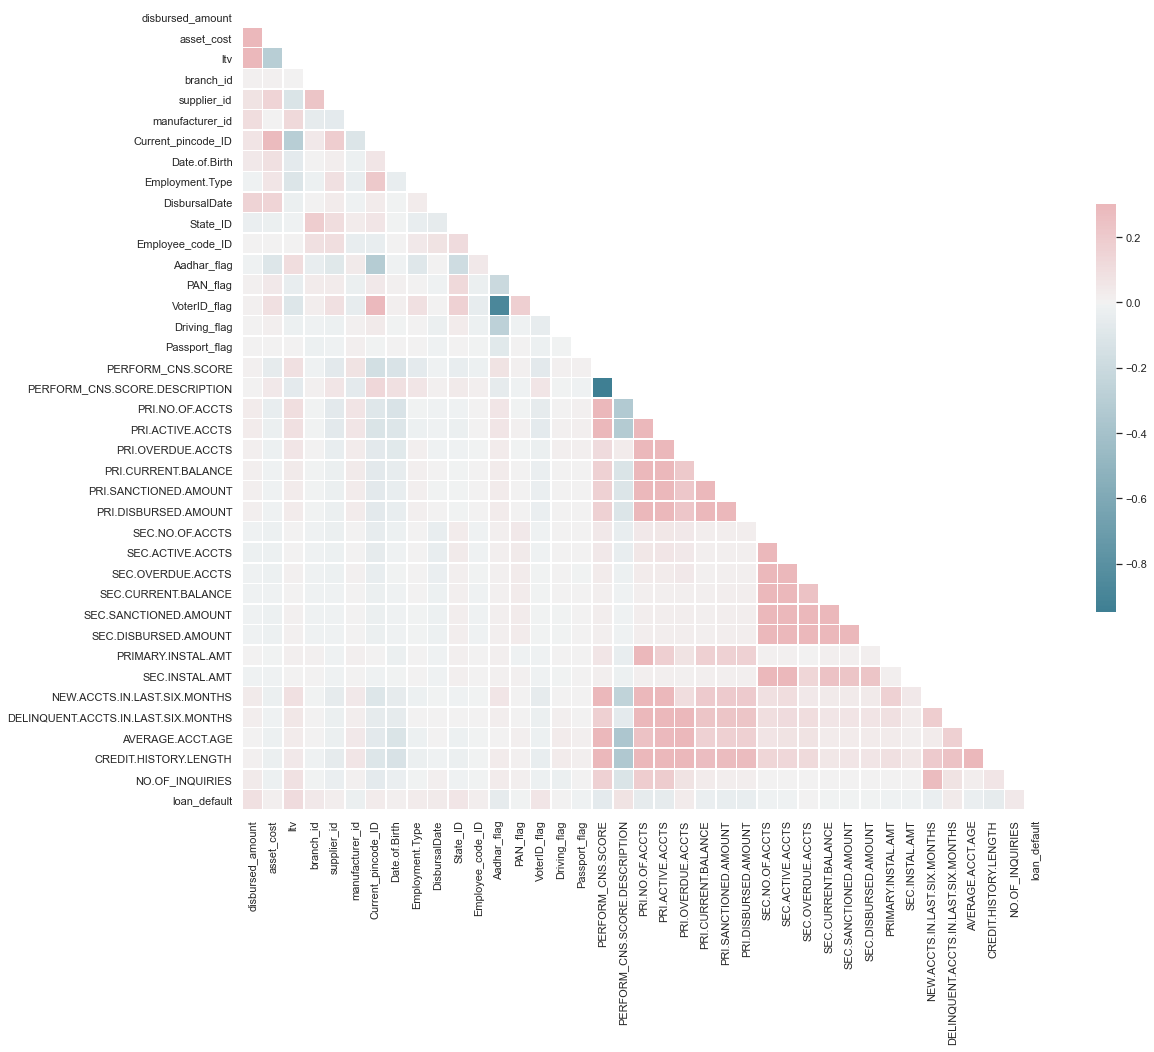

In [358]:
#Set and compute the Correlation Matrix:
sns.set(style="white")
corr = dataset2.corr()
#Generate a mask for the upper triangle:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
#Set up the matplotlib figure and a diverging colormap:
f, ax = plt.subplots(figsize=(18, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
#Draw the heatmap with the mask and correct aspect ratio:
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [359]:
model = PCA()
model.fit(pca_data)
pca_features = model.fit_transform(pca_data)

In [360]:
model.explained_variance_

array([3.09241051e+12, 1.05028471e+11, 5.59817753e+10, 2.88317899e+10,
       3.93716078e+09, 1.18910424e+09, 4.44104686e+08, 5.48707252e+07,
       3.31898310e+07, 1.19484943e+07, 1.10912903e+07, 7.20547079e+06,
       4.21617710e+06, 9.40935309e+05, 1.05840298e+05, 4.63945194e+03,
       6.89005446e+02, 6.06422874e+02, 4.73398236e+02, 5.52846626e+01,
       1.87112117e+01, 1.30297490e+01, 8.51147595e+00, 2.21643757e+00,
       1.15708570e+00, 4.57199633e-01, 3.31378046e-01, 2.76941241e-01,
       2.35606557e-01, 2.14382270e-01, 2.09008288e-01, 1.89978395e-01,
       9.72944938e-02, 6.60908304e-02, 3.18639157e-02, 1.78322281e-02,
       6.79179749e-03, 6.72620226e-03, 1.78249697e-03])

In [361]:
model.explained_variance_ratio_

array([9.40529452e-01, 3.19434855e-02, 1.70263644e-02, 8.76893525e-03,
       1.19745281e-03, 3.61655593e-04, 1.35070533e-04, 1.66884483e-05,
       1.00943951e-05, 3.63402943e-06, 3.37331837e-06, 2.19148055e-06,
       1.28231317e-06, 2.86177196e-07, 3.21903955e-08, 1.41104849e-09,
       2.09554945e-10, 1.84438182e-10, 1.43979908e-10, 1.68143438e-11,
       5.69085042e-12, 3.96288351e-12, 2.58869053e-12, 6.74109987e-13,
       3.51917436e-13, 1.39053246e-13, 1.00785717e-13, 8.42292421e-14,
       7.16576614e-14, 6.52024812e-14, 6.35680319e-14, 5.77802576e-14,
       2.95912643e-14, 2.01009446e-14, 9.69112962e-15, 5.42351529e-15,
       2.06566545e-15, 2.04571524e-15, 5.42130772e-16])

## shows relation in barplot sum and cumulative sum

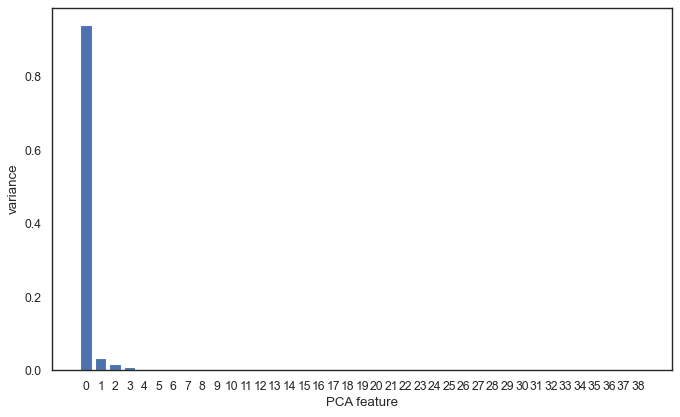

In [362]:
figure(figsize=(10, 6), dpi=80)

features = range(model.n_components_)

plt.bar(features, model.explained_variance_ratio_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

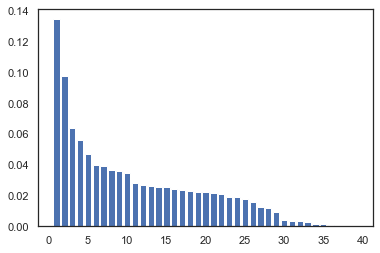

In [363]:
pca = PCA()
pca.fit(scale(pca_data))
plt.bar(range(1,1+pca.n_components_),pca.explained_variance_ratio_)
plt.show()

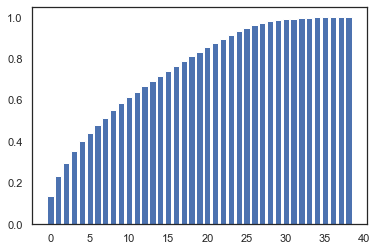

In [364]:
plt.bar(range(pca.n_components_),np.cumsum(pca.explained_variance_ratio_))
plt.show()

### Chceking importance using SVM and PCA

In [365]:
# pca_data = pca_data.sample(n=20_000)

In [366]:
pca_data['loan_default'].value_counts()

0.0    25000
1.0    10000
Name: loan_default, dtype: int64

In [367]:
X_p = pca_data.drop(['loan_default'], axis=1)
y_p = pca_data['loan_default'].values




label_encoder = LabelEncoder()
y_p = label_encoder.fit_transform(y_p)

print(f"X.shape: {X_p.shape} y.shape: { y_p.shape}")

X.shape: (35000, 38) y.shape: (35000,)


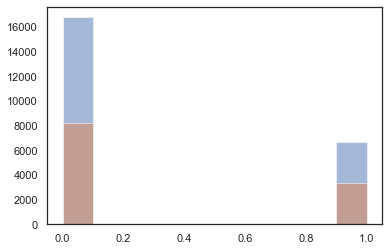

In [368]:
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_p, y_p, test_size=0.33, random_state=42)

plt.hist(y_train_p, alpha=0.5)
plt.hist(y_test_p, alpha=0.5)
plt.show()

In [369]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_p)
pca = PCA()
X_pca = pca.fit_transform(X_train_scaled)
total_explained_variance = pca.explained_variance_ratio_.cumsum()
n_over_95 = len(total_explained_variance[total_explained_variance >= .95])
n_to_reach_95 = X_p.shape[1] - n_over_95 + 1
print("Number features: {}\tTotal Variance Explained: {}".format(n_to_reach_95, total_explained_variance[n_to_reach_95 - 1]))

Number features: 26	Total Variance Explained: 0.9539262328780996


In [370]:
pipe = Pipeline([('scaler', StandardScaler()),
 ('pca', PCA(n_components=n_to_reach_95)),
 ('clf', RandomForestClassifier())])
pipe.fit(X_train_p,y_train_p)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=26)),
                ('clf', RandomForestClassifier())])

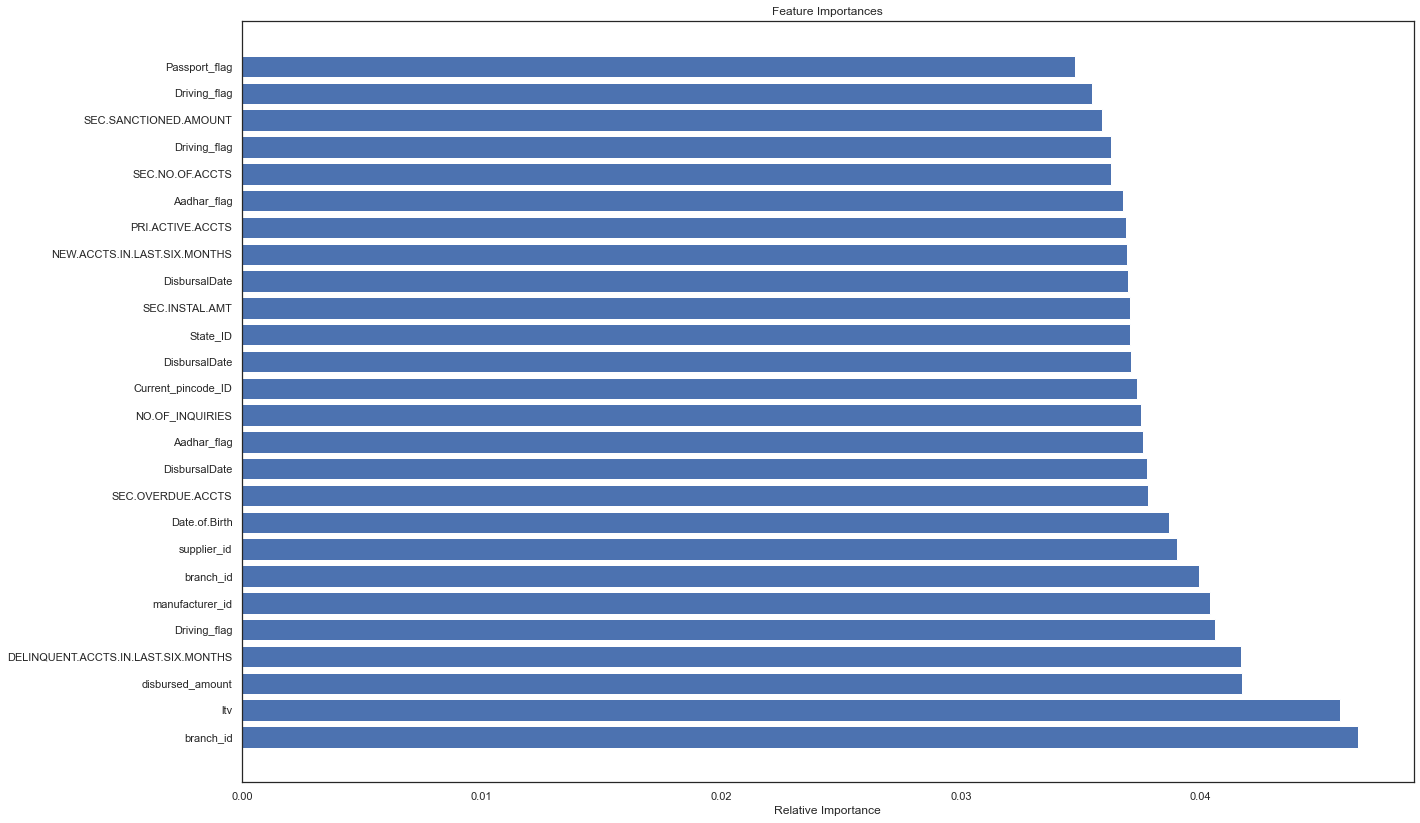

In [371]:
model = pipe.steps[1][1]
n_pcs= model.components_.shape[0]
initial_feature_names = X_train_p.columns
most_important = [np.abs(model.components_[i]).argmax() for i in     range(n_pcs)]
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]
zipped_feats = zip(most_important_names, pipe.steps[2][1].feature_importances_)
zipped_feats = sorted(zipped_feats, key=lambda x: x[1], reverse=True)
features, importances = zip(*zipped_feats)
top_features = features[:28]
top_importances = importances[:28]
plt.figure(figsize=(21,14)) 
plt.title('Feature Importances')
plt.barh(range(len(top_importances)), top_importances, color='b', align='center')
plt.yticks(range(len(top_importances)), top_features)
plt.xlabel('Relative Importance')
plt.show()

In [372]:
# top_features = features[:28]
top_features=list(set(top_features))
top_features

['ltv',
 'SEC.NO.OF.ACCTS',
 'PRI.ACTIVE.ACCTS',
 'Passport_flag',
 'State_ID',
 'NEW.ACCTS.IN.LAST.SIX.MONTHS',
 'NO.OF_INQUIRIES',
 'SEC.OVERDUE.ACCTS',
 'Current_pincode_ID',
 'Date.of.Birth',
 'Driving_flag',
 'branch_id',
 'SEC.SANCTIONED.AMOUNT',
 'disbursed_amount',
 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
 'supplier_id',
 'Aadhar_flag',
 'DisbursalDate',
 'manufacturer_id',
 'SEC.INSTAL.AMT']

In [373]:
logreg001 = LogisticRegression(C=0.001, penalty='l1', solver='liblinear').fit(X_train_p, y_train_p)

print("Training set score: {:.3f}".format(logreg001.score(X_train_p, y_train_p)))
print("Test set score: {:.3f}".format(logreg001.score(X_test_p, y_test_p)))

print(f'f1 score {metrics.f1_score(y_test_p , logreg001.predict(X_test_p))}')

print(f'accuracy_score {metrics.accuracy_score(y_test_p , logreg001.predict(X_test_p))}')
 

Training set score: 0.715
Test set score: 0.712
f1 score 0.00596836765144733
accuracy_score 0.7116017316017316


In [374]:
logreg1 = LogisticRegression(C=1, penalty='l1', solver='liblinear').fit(X_train_p, y_train_p)

print("Training set score: {:.3f}".format(logreg1.score(X_train_p, y_train_p)))
print("Test set score: {:.3f}".format(logreg1.score(X_test_p, y_test_p)))

Training set score: 0.716
Test set score: 0.712


In [375]:
logreg100 = LogisticRegression(C=100, penalty='l1', solver='liblinear').fit(X_train_p, y_train_p)

print("Training set score: {:.3f}".format(logreg100.score(X_train_p, y_train_p)))
print("Test set score: {:.3f}".format(logreg100.score(X_test_p, y_test_p)))

Training set score: 0.716
Test set score: 0.712


Training accuracy of l1 logreg with C=0.001: 0.58
Test accuracy of l1 logreg with C=0.001: 0.58
Training accuracy of l1 logreg with C=1.000: 0.60
Test accuracy of l1 logreg with C=1.000: 0.60
Training accuracy of l1 logreg with C=100.000: 0.60
Test accuracy of l1 logreg with C=100.000: 0.60


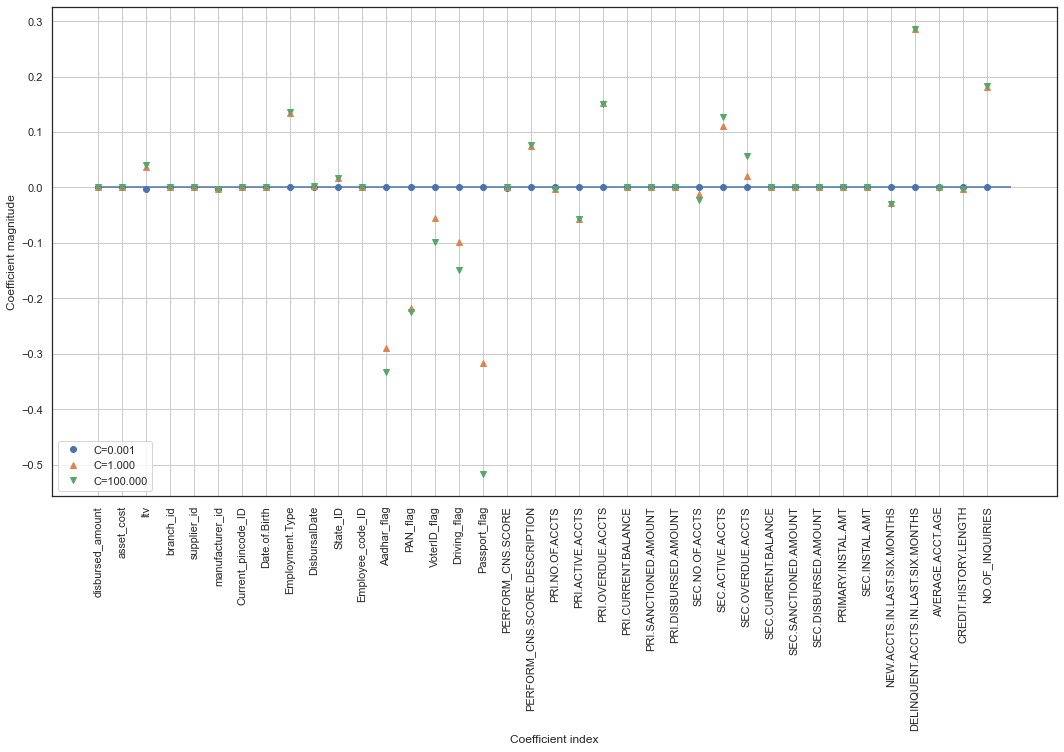

In [302]:
plt.figure(figsize=(18,9)) 
for C, marker in zip([0.001, 1, 100], ['o', '^', 'v']):
    lr_l1 = LogisticRegression(C=C, penalty="l1", solver='liblinear').fit(X_train_p, y_train_p)
    print("Training accuracy of l1 logreg with C={:.3f}: {:.2f}".format(C, lr_l1.score(X_train_p, y_train_p)))
    print("Test accuracy of l1 logreg with C={:.3f}: {:.2f}".format(C, lr_l1.score(X_test_p, y_test_p)))
    plt.plot(lr_l1.coef_.T, marker, label="C={:.3f}".format(C))

   
plt.xticks(range(X_p.columns.shape[0]), X_p.columns, rotation=90)
plt.hlines(0, 0, X_p.columns.shape[0])
plt.xlabel("Coefficient index")
plt.ylabel("Coefficient magnitude")
# plt.ylim(-5, 5)
plt.grid(b=True)
plt.legend(loc=3)
plt.show()


### I will use  26 columns which	Total Variance Explained: 0.95

In [253]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 185068 to 76924
Data columns (total 39 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   disbursed_amount                     20000 non-null  float64       
 1   asset_cost                           20000 non-null  float64       
 2   ltv                                  20000 non-null  float64       
 3   branch_id                            20000 non-null  float64       
 4   supplier_id                          20000 non-null  float64       
 5   manufacturer_id                      20000 non-null  float64       
 6   Current_pincode_ID                   20000 non-null  float64       
 7   Date.of.Birth                        20000 non-null  datetime64[ns]
 8   Employment.Type                      20000 non-null  object        
 9   DisbursalDate                        20000 non-null  datetime64[ns]
 10  State

# Prepare data to next step (train / test split) 

In [376]:
X = dataset.drop(['loan_default'], axis=1)
y = dataset['loan_default'].values




label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

print(f"X.shape: {X.shape} y.shape: { y.shape}")

X.shape: (35000, 38) y.shape: (35000,)


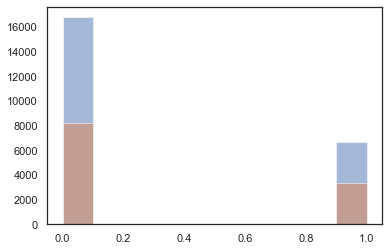

In [377]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

plt.hist(y_train, alpha=0.5)
plt.hist(y_test, alpha=0.5)
plt.show()

In [378]:
print("Number transactions X_train dataset: ", X_train.shape)
print("Number transactions y_train dataset: ", y_train.shape)
print("Number transactions X_test dataset: ", X_test.shape)
print("Number transactions y_test dataset: ", y_test.shape)

Number transactions X_train dataset:  (23450, 38)
Number transactions y_train dataset:  (23450,)
Number transactions X_test dataset:  (11550, 38)
Number transactions y_test dataset:  (11550,)


In [379]:
column_to_cat = list()

for column,types in zip(X_train.columns,X_train.dtypes):
    if  types =='float64' or types == 'int64':
        continue
    else:
        column_to_cat.append(column)
column_to_cat

X_train[column_to_cat]

,Date.of.Birth,Employment.Type,DisbursalDate,PERFORM_CNS.SCORE.DESCRIPTION
208068,1976-03-12,Self employed,2018-08-24,No Bureau History Available
30785,1997-12-25,Self employed,2018-09-12,No Bureau History Available
211416,1996-07-06,Salaried,2018-08-31,B-Very Low Risk
31701,1995-12-22,Salaried,2018-08-13,B-Very Low Risk
230037,1991-01-01,Self employed,2018-10-24,No Bureau History Available
...,...,...,...,...
123041,1979-05-03,Salaried,2018-08-30,K-High Risk
220276,1993-05-08,Self employed,2018-10-27,No Bureau History Available
145130,1981-12-24,Self employed,2018-10-31,C-Very Low Risk
65710,1976-06-05,Self employed,2018-08-10,K-High Risk


In [380]:
column_to_num = list()

for column,types in zip(X_train.columns,X_train.dtypes):
    if  types =='float64' or types == 'int64':
        column_to_num.append(column)
    else:
        continue        

## Create OneHotEncoder for numeric and category values

### start to biuild Pipe line of pracess

In [381]:
# A class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [382]:
# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

## OneHotEncoder for category values

In [383]:
# from future_encoders import OneHotEncoder
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(column_to_cat)),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False, handle_unknown = 'ignore')),
    ])


cat_pipeline.fit_transform(X_train)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [384]:
num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(column_to_num)),
        ("imputer", SimpleImputer(strategy="median")),
    ])

num_pipeline.fit_transform(X_train)

array([[4.5145e+04, 6.8615e+04, 6.8500e+01, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [7.0317e+04, 8.3041e+04, 8.6700e+01, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [3.8969e+04, 8.8039e+04, 4.7520e+01, ..., 8.0000e+00, 8.0000e+00,
        0.0000e+00],
       ...,
       [6.9343e+04, 7.8963e+04, 8.9560e+01, ..., 6.0000e+00, 1.3000e+01,
        2.0000e+00],
       [5.0403e+04, 5.8851e+04, 8.7680e+01, ..., 7.0000e+00, 1.2000e+01,
        0.0000e+00],
       [6.2047e+04, 7.1436e+04, 8.9030e+01, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

## Connect both Pipelines

In [385]:
from sklearn.pipeline import FeatureUnion
preprocess_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

# Creating models

In [386]:
seed=123
kfold = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

## LinearSVC

In [387]:

pipe = Pipeline([('preprocessing', preprocess_pipeline),
                 ('PCA',PCA(n_components=26)),
                 ('classifier', LinearSVC(C=1))])

param_grid = {
            'classifier__C': [ 0.00001,0.0001,0.001,0.01,0.1,1,100,10000,100000] # in test split 0.2 the best is 0,1 , IN SPLIT 0.33 10 or 0.1
            
}

grid_1 = GridSearchCV(pipe, param_grid, cv=kfold, return_train_score=True)

grid_1.fit(X_train, y_train)
grid_1.best_params_


/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations

{'classifier__C': 10000}

## SVC RBF

In [ ]:
pipe_2 = Pipeline([('preprocessing', preprocess_pipeline),
                   ('PCA',PCA(n_components=26)),
                   ('classifier', SVC(C=1,kernel='rbf', probability=True))])

param_grid_2 = {
            'classifier__C': [  10,100,104,108,110,115],#{'classifier__C': 0.01, 'classifier__gamma': 0.01}
            'classifier__gamma': [0.00000000001,0.0000000001,0.000000001,0.00000001,0.0000001,0.000001]
}

grid_2 = GridSearchCV(pipe_2, param_grid_2, cv=kfold, return_train_score=True)

grid_2.fit(X_train, y_train)
grid_2.best_params_

In [ ]:
results = pd.DataFrame(grid_2.cv_results_)

In [ ]:
len(results.mean_test_score)

In [ ]:
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img

In [ ]:
scores = np.array(results.mean_test_score).reshape(6, 6,1)
scores = scores[:,:,0]
scores

In [ ]:
heatmap(scores, xlabel='classifier__gamma', xticklabels=param_grid_2['classifier__gamma'], ylabel='classifier__C', yticklabels=param_grid_2['classifier__C'], cmap="viridis")
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(grid_2, X_train, y_train, cv=3)
y_train_pred

In [ ]:

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_train_pred)

## LogisticRegression

In [389]:
from sklearn.linear_model import LogisticRegression

pipe_3 = Pipeline([('preprocessing', preprocess_pipeline),
                   ('PCA', PCA(n_components=26)),
                   ('classifier', LogisticRegression(C=1,penalty='l2', max_iter=150))
                  ])

param_grid_3 = {
            'classifier__C': [0.00001,0.0001,0.001 ,0.01], # [0.001 ,0.01, 0.1, 1] best 0.001
            'classifier__penalty':['l2','l1']
}

grid_3 = GridSearchCV(pipe_3, param_grid_3, cv=kfold, return_train_score=True)

grid_3.fit(X_train, y_train)
grid_3.best_params_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

{'classifier__C': 0.0001, 'classifier__penalty': 'l2'}

### Checking  Confusion Matrix for Logistic Regression

In [390]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(grid_3, X_train, y_train, cv=3)
y_train_pred.mean(axis=0)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipel

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipel

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got 

0.5637100213219616

In [391]:


from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_train_pred)

array([[7992, 8790],
       [2239, 4429]])

# KNeighborsClassifier

### Checking corelation between accuracy and K Neighbors

In [393]:
X_train_neig = copy.deepcopy(X_train)
X_test_neig = copy.deepcopy(X_test)
name_columns = []
for name in X_train.columns:
    name_columns.append(name)
name_columns

label_encoder = LabelEncoder()
for column in X_train_neig[name_columns]:
    X_train_neig[column]= label_encoder.fit_transform(X_train_neig[column])

for column in X_test_neig[name_columns]:
    X_test_neig[column]= label_encoder.fit_transform(X_test_neig[column])   

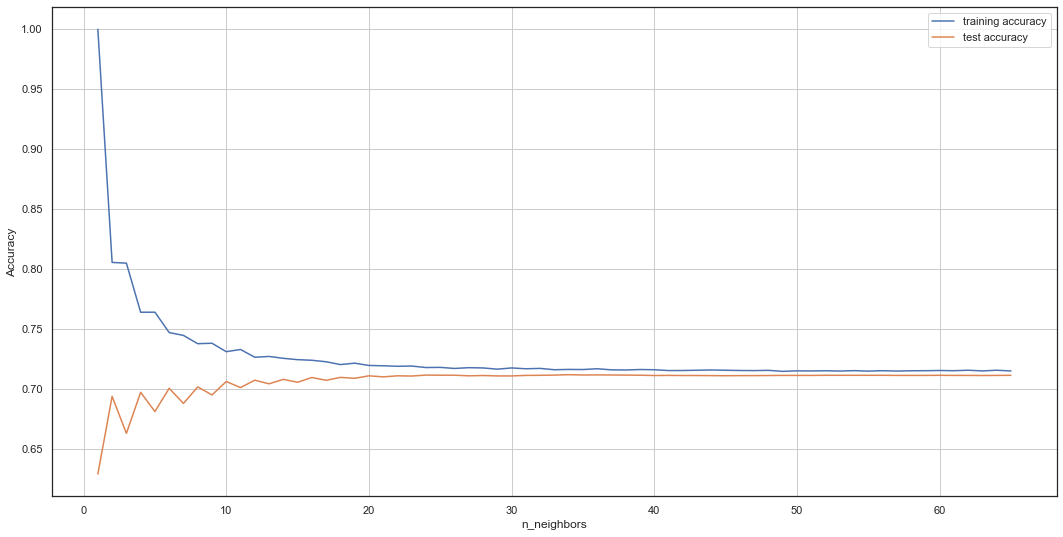

In [394]:
training_accuracy = []
test_accuracy = []

neighbors_settings = range(1, 66)

for n_neighbors in neighbors_settings:
    
    # build the model
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train_neig, y_train)
    
    # record training set accuracy
    training_accuracy.append(clf.score(X_train_neig, y_train))
    
    # record generalization accuracy
    test_accuracy.append(clf.score(X_test_neig, y_test))

plt.figure(figsize=(18,9)) 
plt.grid(b=True)
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()
plt.show()

In [395]:
# from sklearn.neighbors import KNeighborsClassifier

pipe_4 = Pipeline([('preprocessing', preprocess_pipeline),
                   ('PCA',PCA(n_components=26)),
                   ('classifier', KNeighborsClassifier(n_neighbors=2, metric='euclidean'))
                  ])



param_grid_4 = {
            'classifier__n_neighbors':list(range(15,65)), #[ 30,40,50,60],
            'classifier__metric': ['euclidean']
}


grid_4 = GridSearchCV(pipe_4, param_grid_4, cv=kfold, return_train_score=True)

grid_4.fit(X_train, y_train)
grid_4.best_params_

{'classifier__metric': 'euclidean', 'classifier__n_neighbors': 62}

## DecisionTreeClassifier

In [396]:
from sklearn.tree import DecisionTreeClassifier

pipe_5 = Pipeline([('preprocessing', preprocess_pipeline), 
                   ('PCA',PCA(n_components=26)),
                   ('classifier', DecisionTreeClassifier())])

param_grid_5 = {
            'classifier__max_depth': [1,2,3,5],
            'classifier__max_leaf_nodes': [1,2,3,4],
            'classifier__min_samples_split': [1,2,3,5]
            
}


grid_5 = GridSearchCV(pipe_5, param_grid_5, cv=kfold, return_train_score=True)

grid_5.fit(X_train, y_train)
grid_5.best_params_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 898, in fit
    super().fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score o

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 898, in fit
    super().fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 293, in fit
    raise ValueError(("max_leaf_nodes {0} must be either None "
ValueError: max_leaf_nodes 1 must be either None or larger than 1

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/anaconda3/lib/p

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 898, in fit
    super().fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 293, in fit
    raise ValueError(("max_leaf_nodes {0} must be either None "
ValueError: max_leaf_nodes 1 must be either None or larger than 1

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/anaconda3/lib/p

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 898, in fit
    super().fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score o

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 898, in fit
    super().fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score o

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 898, in fit
    super().fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 293, in fit
    raise ValueError(("max_leaf_nodes {0} must be either None "
ValueError: max_leaf_nodes 1 must be either None or larger than 1

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/anaconda3/lib/p

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 898, in fit
    super().fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 293, in fit
    raise ValueError(("max_leaf_nodes {0} must be either None "
ValueError: max_leaf_nodes 1 must be either None or larger than 1

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/anaconda3/lib/p

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 898, in fit
    super().fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score o

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 898, in fit
    super().fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score o

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 898, in fit
    super().fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 293, in fit
    raise ValueError(("max_leaf_nodes {0} must be either None "
ValueError: max_leaf_nodes 1 must be either None or larger than 1

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/anaconda3/lib/p

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 898, in fit
    super().fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score o

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 898, in fit
    super().fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score o

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 898, in fit
    super().fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score o

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 898, in fit
    super().fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 293, in fit
    raise ValueError(("max_leaf_nodes {0} must be either None "
ValueError: max_leaf_nodes 1 must be either None or larger than 1

  warnings.warn("Estimator fit failed. The score on this train-test"
/opt/anaconda3/lib/p

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 898, in fit
    super().fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score o

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 898, in fit
    super().fit(
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 237, in fit
    raise ValueError("min_samples_split must be an integer "
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  warnings.warn("Estimator fit failed. The score o

{'classifier__max_depth': 1,
 'classifier__max_leaf_nodes': 2,
 'classifier__min_samples_split': 2}

## BaggingClassifier

In [397]:
# from sklearn.ensemble import BaggingClassifier
# from sklearn.tree import DecisionTreeClassifier

pipe_6 = Pipeline([('preprocessing', preprocess_pipeline),
                   ('PCA',PCA(n_components=26)),
                   ('classifier', BaggingClassifier(
                                    DecisionTreeClassifier(random_state=42), n_estimators=500,
                                    max_samples=100, bootstrap=True, random_state=42))
                  ])

param_grid_6 = {'classifier__max_samples': [9,10,11],
                'classifier__n_estimators': [49,50,51]
              
             }

grid_6 = GridSearchCV(pipe_6, param_grid_6, cv=kfold, return_train_score=True)

grid_6.fit(X_train, y_train)
grid_6.best_params_

{'classifier__max_samples': 10, 'classifier__n_estimators': 50}

## RandomForestClassifier

In [398]:
from sklearn.ensemble import RandomForestClassifier

pipe_7 = Pipeline([('preprocessing', preprocess_pipeline), 
                   ('PCA',PCA(n_components=26)),
                   ('classifier', RandomForestClassifier(n_estimators=500, max_leaf_nodes=16))
                  ])

param_grid_7 = {'classifier__n_estimators': [4,5,6],
              'classifier__max_leaf_nodes': [8,9,10,11],
              'classifier__max_depth': [8,9,10,11]
             }

grid_7 = GridSearchCV(pipe_7, param_grid_7, cv=kfold, return_train_score=True)

grid_7.fit(X_train, y_train)
grid_7.best_params_
#\n{'classifier__max_depth': 5,\n 'classifier__max_leaf_nodes': 10,\n 'classifier__n_estimators': 10}\n "

{'classifier__max_depth': 10,
 'classifier__max_leaf_nodes': 11,
 'classifier__n_estimators': 4}

## ExtraTreesClassifier

In [399]:
from sklearn.ensemble import ExtraTreesClassifier

pipe_8 = Pipeline([('preprocessing', preprocess_pipeline), 
                   ('PCA',PCA(n_components=26)),
                   ('classifier', ExtraTreesClassifier(n_estimators=500, max_leaf_nodes=16))
                  ])

param_grid_8 = {'classifier__max_depth': [5,6,7,8,9],
                'classifier__max_leaf_nodes': [15,16,17],
                'classifier__n_estimators': [52,53,54]
              
              
             }

grid_8 = GridSearchCV(pipe_8, param_grid_8, cv=kfold, return_train_score=True)

grid_8.fit(X_train, y_train)
grid_8.best_params_

{'classifier__max_depth': 5,
 'classifier__max_leaf_nodes': 15,
 'classifier__n_estimators': 52}

## GradientBoostingClassifier

In [400]:
from sklearn.ensemble import GradientBoostingClassifier

pipe_9 = Pipeline([('preprocessing', preprocess_pipeline),
                   ('PCA',PCA(n_components=26)),
                   ('classifier', GradientBoostingClassifier(
                       n_estimators=1, 
                      learning_rate=0.5, 
                      random_state=42))
                  ])


param_grid_9 = {'classifier__n_estimators': [59,60,61,62,65],
              'classifier__learning_rate': [0.001,0.1,1,10]
             }

grid_9 = GridSearchCV(pipe_9, param_grid_9, cv=kfold, return_train_score=True)

grid_9.fit(X_train, y_train)
grid_9.best_params_

{'classifier__learning_rate': 0.1, 'classifier__n_estimators': 62}

##  R XgBoos

In [401]:
# from scipy.stats.distributions import uniform, randint
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import xgboost
#

pipe_10 = Pipeline([('preprocessing', preprocess_pipeline),
                    ('PCA',PCA(n_components=26)),
                   ('classifier', xgboost.XGBClassifier(n_estimators=1, 
                      learning_rate=0.5, 
                      random_state=42))
                  ])


param_grid_10 = {
    'classifier__colsample_bytree': uniform(0.5, 0.5),
    'classifier__gamma': uniform(0,2),
    'classifier__learning_rate': uniform(0.001, 0.1-0.001),
    'classifier__max_depth': randint(3, 11),
    'classifier__min_child_weight': randint(1, 11),
    'classifier__n_estimators': randint(50, 400), 
    'classifier__subsample': uniform(0.5, 0.5),
    
}

grid_10 = RandomizedSearchCV(n_iter=100,estimator=pipe_10, 
                             param_distributions=param_grid_10, 
                      cv=kfold, 
                      return_train_score=True)

grid_10.fit(X_train, y_train)
grid_10.best_params_

{'classifier__colsample_bytree': 0.5272113064019506,
 'classifier__gamma': 0.39062315218568067,
 'classifier__learning_rate': 0.07282948319974002,
 'classifier__max_depth': 4,
 'classifier__min_child_weight': 4,
 'classifier__n_estimators': 195,
 'classifier__subsample': 0.9789707100594585}

### Checking Confusion Matrix for R XgBoos

In [402]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(grid_10, X_train, y_train, cv=3)


from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_train_pred)

array([[16630,   152],
       [ 6504,   164]])

## xgboost

In [403]:
# from scipy.stats.distributions import uniform, randint
# from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# import xgboost




pipe_11 = Pipeline([('preprocessing', preprocess_pipeline),
                    ('PCA',PCA(n_components=26)),
                   ('classifier', xgboost.XGBClassifier(n_estimators=1, 
                      learning_rate=0.5, 
                      random_state=42))
                  ])


param_grid_11 ={
    'classifier__subsample': [ 0.8,0.9,1,1.1],
    'classifier__n_estimators': [90, 100, 110,120],
    'classifier__min_child_weight': [1, 5, 10],
    'classifier__max_depth': [2,3, 4],
    'classifier__learning_rate': [0.001, 0.01, 0.05, 0.1],
    'classifier__gamma': [0, 0.5, 1, 2],
    'classifier__colsample_bytree': [ 0.7,0.8, 0.9,]
}

grid_11 = RandomizedSearchCV(n_iter=100,estimator=pipe_11, 
                             param_distributions=param_grid_11, 
                      cv=kfold, 
                      return_train_score=True)

grid_11.fit(X_train, y_train)
grid_11.best_params_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py", line 818, in fit
    self._Booster = train(xgb_options, train_dmatrix,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 208, in train
    return _train_internal(params, dtrain,
  File "/opt/anaconda3/lib/python3.8/site-packages/xgboost/training.py", line 75, in _train_internal
    bst.update(dtrain, i, obj)
  File "/opt/anac

{'classifier__subsample': 0.9,
 'classifier__n_estimators': 100,
 'classifier__min_child_weight': 5,
 'classifier__max_depth': 4,
 'classifier__learning_rate': 0.05,
 'classifier__gamma': 2,
 'classifier__colsample_bytree': 0.9}

## AdaBoostClassifier

In [404]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

pipe_12 = Pipeline([('preprocessing', preprocess_pipeline), 
                    ('PCA',PCA(n_components=26)),
                   ('classifier', AdaBoostClassifier(
                        DecisionTreeClassifier(max_depth=1), 
                        n_estimators=1,
                        learning_rate=0.5, 
                        algorithm="SAMME.R",
                        random_state=42)
                   )
                  ])


param_grid_12 = {'classifier__n_estimators': [52,53,54,55,56],
              'classifier__learning_rate': [0.1, 0.2,0.5,0.8,0.9, 1,1.1,1.2,1.5],
             }

grid_12 = GridSearchCV(pipe_12, param_grid_12, cv=kfold, return_train_score=True)

grid_12.fit(X_train, y_train)
grid_12.best_params_

{'classifier__learning_rate': 0.5, 'classifier__n_estimators': 55}

In [405]:
from sklearn.ensemble import VotingClassifier

voting_clf = VotingClassifier(
    estimators=[
                ('grid_5', grid_5.best_estimator_), 
                ('grid_6', grid_6.best_estimator_), 
                ('grid_8', grid_8.best_estimator_),
                ('grid_9', grid_9.best_estimator_),
               ],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('grid_5',
                              Pipeline(steps=[('preprocessing',
                                               FeatureUnion(transformer_list=[('num_pipeline',
                                                                               Pipeline(steps=[('select_numeric',
                                                                                                DataFrameSelector(attribute_names=['disbursed_amount',
                                                                                                                                   'asset_cost',
                                                                                                                                   'ltv',
                                                                                                                                   'branch_id',
                                                                                                             

# Comparing Models

In [237]:
from sklearn import  metrics


models = []
models.append(('SVM linear', grid_1.best_estimator_))
models.append(('SVM rbf', grid_2.best_estimator_))
models.append(('LR', grid_3.best_estimator_))
models.append(('KNN', grid_4.best_estimator_))
models.append(('DecisionTreeClassifier', grid_5.best_estimator_))
models.append(('BaggingClassifier', grid_6.best_estimator_))
models.append(('RandomForestClassifier', grid_7.best_estimator_))
models.append(('ExtraTrees', grid_8.best_estimator_))
models.append(('GrBoos', grid_9.best_estimator_))
models.append(('R XgBoos', grid_10.best_estimator_))
models.append(('XgBoos', grid_11.best_estimator_)) #grid_11
models.append(('AdaBoost', grid_12.best_estimator_))
models.append(('voting_clf', voting_clf))




precision_score = []
recall_score = []
f1_score = []
accuracy_score = []
roc_auc_score = []
for name, model in models:
    print(name)
    print("recall_score: {}".format( metrics.recall_score(y_test , model.predict(X_test)) ))
    print("f1_score: {}".format( metrics.f1_score(y_test , model.predict(X_test)) ))
    print("accuracy_score: {}".format( metrics.accuracy_score(y_test , model.predict(X_test)) ))
    
    if (name == 'SVM linear'):
        print("roc_auc_score: {}".format( metrics.roc_auc_score(y_test , model.decision_function(X_test)) ))            
    else:
        print("roc_auc_score: {}".format( metrics.roc_auc_score(y_test , model.predict_proba(X_test)[:,1]) ))
    
    precision_score.append(metrics.precision_score(y_test , model.predict(X_test)))
    recall_score.append(metrics.recall_score(y_test , model.predict(X_test)))
    f1_score.append( metrics.f1_score(y_test , model.predict(X_test)))
    accuracy_score.append(metrics.accuracy_score(y_test , model.predict(X_test)))
    if (name == 'SVM linear'):
        roc_auc_score.append(metrics.roc_auc_score(y_test , model.decision_function(X_test)))        
    else:    
        roc_auc_score.append(metrics.roc_auc_score(y_test , model.predict_proba(X_test)[:,1]))

SVM linear
recall_score: 0.9931454683929931
f1_score: 0.6626016260162602
accuracy_score: 0.49696969696969695
roc_auc_score: 0.5360289057715696
SVM rbf
recall_score: 0.682025894897182
f1_score: 0.6017134218041323
accuracy_score: 0.5509469696969697
roc_auc_score: 0.5703595314606529
LR
recall_score: 0.6378522467631379
f1_score: 0.5806898942624372
accuracy_score: 0.5418560606060606
roc_auc_score: 0.5615937890815341
KNN
recall_score: 0.5936785986290937
f1_score: 0.5676315310395048
accuracy_score: 0.5501893939393939
roc_auc_score: 0.5755789878158879
DecisionTreeClassifier
recall_score: 0.7174409748667174
f1_score: 0.6177049180327869
accuracy_score: 0.5583333333333333
roc_auc_score: 0.5617930887634007
BaggingClassifier
recall_score: 0.6492764661081493
f1_score: 0.5790456783834267
accuracy_score: 0.5304924242424243
roc_auc_score: 0.5354515249797545
RandomForestClassifier
recall_score: 0.6016755521706016
f1_score: 0.5882352941176472
accuracy_score: 0.581060606060606
roc_auc_score: 0.61386927777

SVM linear
SVM rbf
LR
KNN
DecisionTreeClassifier
BaggingClassifier
RandomForestClassifier
ExtraTrees
GrBoos
R XgBoos
XgBoos
AdaBoost
voting_clf


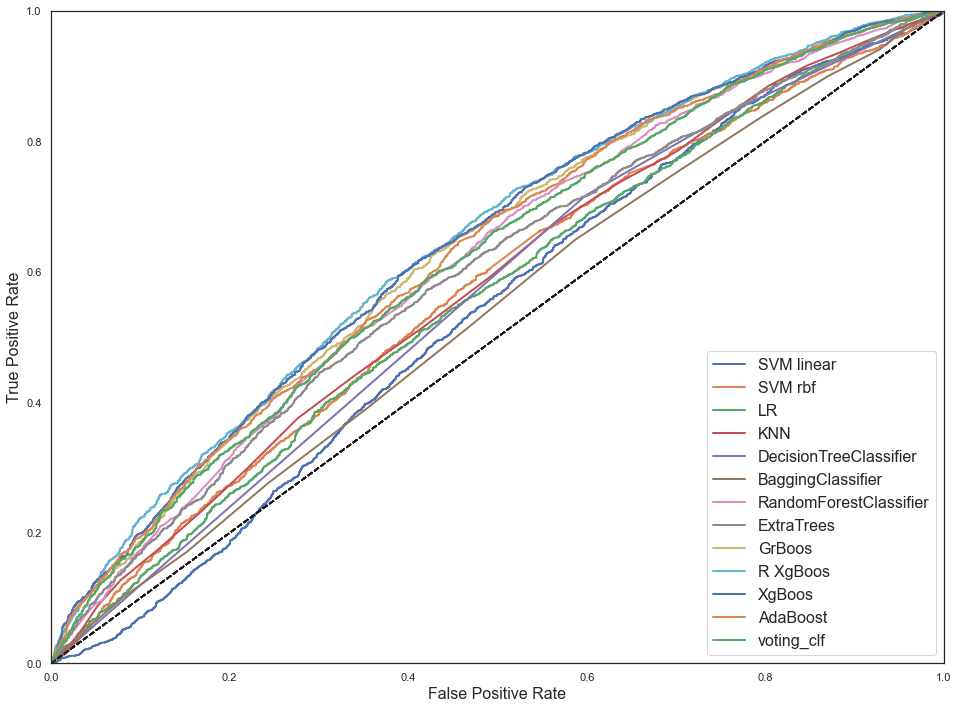

In [229]:
from sklearn.metrics import roc_curve

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(16, 12))
for name, model in models:
    print(name)
    if (name == 'SVM linear'):
        y_scores = model.decision_function(X_test)
    else: 
        y_scores = model.predict_proba(X_test)[:,1]        
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    plot_roc_curve(fpr, tpr, name)

plt.legend(loc="lower right", fontsize=16)
plt.show()
    

In [230]:
valuse_list = []
for name,model in models:
    valuse_list.append(name)

d = {'precision_score': precision_score, 
     'recall_score': recall_score, 
     'f1_score': f1_score,
     'accuracy_score' : accuracy_score,
     'roc_auc_score' : roc_auc_score
    }
df = pd.DataFrame(data=d)
df.insert(loc=0, column='Method', value=valuse_list)

df

,Method,precision_score,recall_score,f1_score,accuracy_score,roc_auc_score
0,SVM linear,0.497141,0.993145,0.662602,0.496970,0.536029
1,SVM rbf,0.538323,0.682026,0.601713,0.550947,0.570391
2,LR,0.532930,0.637852,0.580690,0.541856,0.561594
3,KNN,0.543774,0.593679,0.567632,0.550189,0.575579
4,DecisionTreeClassifier,0.542314,0.717441,0.617705,0.558333,0.561793
5,BaggingClassifier,0.522525,0.649276,0.579046,0.530492,0.535452
6,RandomForestClassifier,0.575382,0.601676,0.588235,0.581061,0.613869
7,ExtraTrees,0.551468,0.679360,0.608770,0.565720,0.595462
8,GrBoos,0.579948,0.674029,0.623459,0.595076,0.631275
9,R XgBoos,0.587366,0.665651,0.624063,0.601136,0.641572
